# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

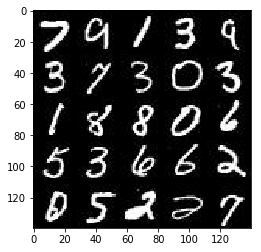

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

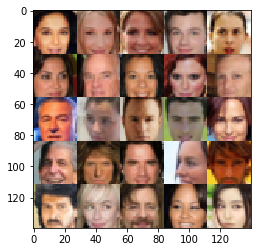

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    realinp = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    zinp = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='learningrate')

    return (realinp, zinp, lr)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def lrelu(x, leak=0.2):
    ''' leaky relu function '''
    f1 = 0.5 * (1 + leak)
    f2 = 0.5 * (1 - leak)
    return f1 * x + f2 * abs(x)


def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # leaky relu parameter
        alpha = 0.2
        
        # Input layer is 28x28x3 - out is 14x14x64
        x = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu = lrelu(x, alpha)
        
        x = tf.layers.conv2d(relu, 128, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn = tf.layers.batch_normalization(x, training=True)
        relu = lrelu(bn, alpha)
        # out - 7x7x128
        
        x = tf.layers.conv2d(relu, 256, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn = tf.layers.batch_normalization(x, training=True)
        relu = lrelu(bn, alpha)
        # out - 4x4x256

        # Flatten it
        flat = tf.contrib.layers.flatten(relu)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    with tf.variable_scope('generator', reuse=not is_train):
        
        # leaky relu parameter
        alpha = 0.15
        
    
        # First fully connected layer
        x = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x = tf.reshape(x, (-1, 7, 7, 512))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = lrelu(x, alpha)
        # out 7x7x...


        x = tf.layers.conv2d_transpose(x, 256, 5, strides=2, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training=is_train)
        x = lrelu(x, alpha)
        # 14x14x...


        x = tf.layers.conv2d_transpose(x, 128, 5, strides=2, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training=is_train)
        x = lrelu(x, alpha)
        # 28x28x...


        x = tf.layers.conv2d_transpose(x, 64, 5, strides=1, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training=is_train)
        x = lrelu(x, alpha)
        # 28x28x...


        # Output layer
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 5, strides=1, padding='same',
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28xch
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
import numpy as np

def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real) * np.random.uniform(0.7, 1.2)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_model_fake) * np.random.uniform(0.0, 0.3)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    _, imgw, imgh, nch = data_shape    
    realinp, zinp, lr = model_inputs(imgw, imgh, nch, z_dim)
    
    dloss, gloss = model_loss(realinp, zinp, nch)
    dopt, gopt = model_opt(dloss, gloss, lr, beta1)
    
    print_every=25
    show_every=200
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # scaling batch_images to (-1,1) instead of (-0.5, 0.5) to match
                # the generator tanh output
                batch_images = batch_images * 2
                
                # checking that input values are within (-1, 1) domain
                #minv = np.min(batch_images)
                #maxv = np.max(batch_images)
                #print('values:', minv, maxv)
                #error()
                
                # Run optimizers
                feed = {realinp: batch_images, zinp: batch_z, lr: learning_rate}
                sess.run([gloss, gopt], feed_dict=feed)
                
                g_loss_res, _ = sess.run([gloss, gopt], feed_dict=feed)
                d_loss_res, _ = sess.run([dloss, dopt], feed_dict=feed)                

                if steps % print_every == 0:
                    print("Step {}, (Epoch {}/{})...".format(steps, epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(d_loss_res),
                          "Generator Loss: {:.4f}".format(g_loss_res))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 64, zinp, nch, data_image_mode)
        

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Step 25, (Epoch 1/2)... Discriminator Loss: 2.3902... Generator Loss: 0.5298
Step 50, (Epoch 1/2)... Discriminator Loss: 1.8311... Generator Loss: 1.0117
Step 75, (Epoch 1/2)... Discriminator Loss: 1.6130... Generator Loss: 0.6428
Step 100, (Epoch 1/2)... Discriminator Loss: 1.5827... Generator Loss: 0.9284
Step 125, (Epoch 1/2)... Discriminator Loss: 1.4702... Generator Loss: 0.7294
Step 150, (Epoch 1/2)... Discriminator Loss: 1.4889... Generator Loss: 0.6022
Step 175, (Epoch 1/2)... Discriminator Loss: 1.5046... Generator Loss: 1.1800
Step 200, (Epoch 1/2)... Discriminator Loss: 1.4510... Generator Loss: 0.6104


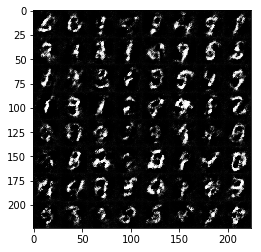

Step 225, (Epoch 1/2)... Discriminator Loss: 1.4972... Generator Loss: 1.2115
Step 250, (Epoch 1/2)... Discriminator Loss: 1.4571... Generator Loss: 0.6804
Step 275, (Epoch 1/2)... Discriminator Loss: 1.4513... Generator Loss: 1.1086
Step 300, (Epoch 1/2)... Discriminator Loss: 1.4150... Generator Loss: 0.7039
Step 325, (Epoch 1/2)... Discriminator Loss: 1.4425... Generator Loss: 0.7847
Step 350, (Epoch 1/2)... Discriminator Loss: 1.4310... Generator Loss: 0.8624
Step 375, (Epoch 1/2)... Discriminator Loss: 1.4546... Generator Loss: 1.1012
Step 400, (Epoch 1/2)... Discriminator Loss: 1.4173... Generator Loss: 0.9186


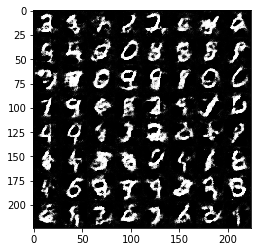

Step 425, (Epoch 1/2)... Discriminator Loss: 1.4678... Generator Loss: 1.0305
Step 450, (Epoch 1/2)... Discriminator Loss: 1.4545... Generator Loss: 0.8644
Step 475, (Epoch 1/2)... Discriminator Loss: 1.4278... Generator Loss: 0.7754
Step 500, (Epoch 1/2)... Discriminator Loss: 1.4357... Generator Loss: 0.6752
Step 525, (Epoch 1/2)... Discriminator Loss: 1.4691... Generator Loss: 1.0148
Step 550, (Epoch 1/2)... Discriminator Loss: 1.4755... Generator Loss: 1.0902
Step 575, (Epoch 1/2)... Discriminator Loss: 1.4373... Generator Loss: 0.8118
Step 600, (Epoch 1/2)... Discriminator Loss: 1.4158... Generator Loss: 0.7824


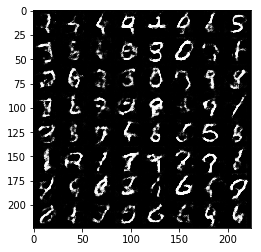

Step 625, (Epoch 1/2)... Discriminator Loss: 1.4087... Generator Loss: 0.9217
Step 650, (Epoch 1/2)... Discriminator Loss: 1.4149... Generator Loss: 0.8411
Step 675, (Epoch 1/2)... Discriminator Loss: 1.4220... Generator Loss: 0.7516
Step 700, (Epoch 1/2)... Discriminator Loss: 1.4481... Generator Loss: 0.9177
Step 725, (Epoch 1/2)... Discriminator Loss: 1.4149... Generator Loss: 0.6143
Step 750, (Epoch 1/2)... Discriminator Loss: 1.3954... Generator Loss: 0.7153
Step 775, (Epoch 1/2)... Discriminator Loss: 1.4326... Generator Loss: 0.8141
Step 800, (Epoch 1/2)... Discriminator Loss: 1.4177... Generator Loss: 0.9120


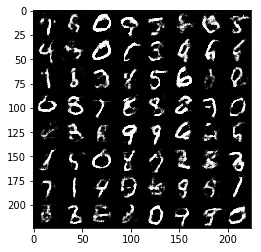

Step 825, (Epoch 1/2)... Discriminator Loss: 1.4337... Generator Loss: 0.7766
Step 850, (Epoch 1/2)... Discriminator Loss: 1.4153... Generator Loss: 0.7626
Step 875, (Epoch 1/2)... Discriminator Loss: 1.4253... Generator Loss: 0.6241
Step 900, (Epoch 1/2)... Discriminator Loss: 1.4172... Generator Loss: 0.8437
Step 925, (Epoch 1/2)... Discriminator Loss: 1.4322... Generator Loss: 0.7112
Step 950, (Epoch 2/2)... Discriminator Loss: 1.4014... Generator Loss: 0.7220
Step 975, (Epoch 2/2)... Discriminator Loss: 1.4396... Generator Loss: 1.0009
Step 1000, (Epoch 2/2)... Discriminator Loss: 1.4324... Generator Loss: 0.7640


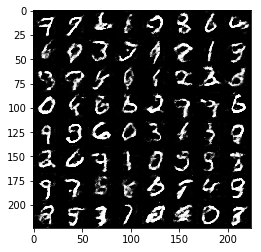

Step 1025, (Epoch 2/2)... Discriminator Loss: 1.4341... Generator Loss: 0.8281
Step 1050, (Epoch 2/2)... Discriminator Loss: 1.4128... Generator Loss: 0.8137
Step 1075, (Epoch 2/2)... Discriminator Loss: 1.3912... Generator Loss: 0.7344
Step 1100, (Epoch 2/2)... Discriminator Loss: 1.4781... Generator Loss: 0.8106
Step 1125, (Epoch 2/2)... Discriminator Loss: 1.4186... Generator Loss: 0.7903
Step 1150, (Epoch 2/2)... Discriminator Loss: 1.3988... Generator Loss: 0.7199
Step 1175, (Epoch 2/2)... Discriminator Loss: 1.4248... Generator Loss: 0.7671
Step 1200, (Epoch 2/2)... Discriminator Loss: 1.4102... Generator Loss: 0.8023


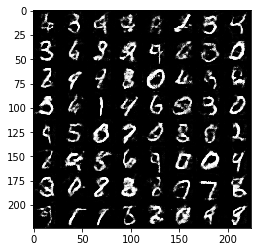

Step 1225, (Epoch 2/2)... Discriminator Loss: 1.4053... Generator Loss: 0.7714
Step 1250, (Epoch 2/2)... Discriminator Loss: 1.4444... Generator Loss: 0.8759
Step 1275, (Epoch 2/2)... Discriminator Loss: 1.4358... Generator Loss: 0.6413
Step 1300, (Epoch 2/2)... Discriminator Loss: 1.4180... Generator Loss: 0.7630
Step 1325, (Epoch 2/2)... Discriminator Loss: 1.4354... Generator Loss: 0.7917
Step 1350, (Epoch 2/2)... Discriminator Loss: 1.4095... Generator Loss: 0.8425
Step 1375, (Epoch 2/2)... Discriminator Loss: 1.4045... Generator Loss: 0.7695
Step 1400, (Epoch 2/2)... Discriminator Loss: 1.4050... Generator Loss: 0.7781


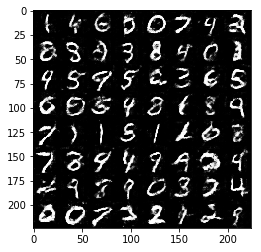

Step 1425, (Epoch 2/2)... Discriminator Loss: 1.4188... Generator Loss: 0.8639
Step 1450, (Epoch 2/2)... Discriminator Loss: 1.4131... Generator Loss: 0.8530
Step 1475, (Epoch 2/2)... Discriminator Loss: 1.4410... Generator Loss: 0.8870
Step 1500, (Epoch 2/2)... Discriminator Loss: 1.4152... Generator Loss: 0.6955
Step 1525, (Epoch 2/2)... Discriminator Loss: 1.4098... Generator Loss: 0.6642
Step 1550, (Epoch 2/2)... Discriminator Loss: 1.4137... Generator Loss: 0.7746
Step 1575, (Epoch 2/2)... Discriminator Loss: 1.4077... Generator Loss: 0.7702
Step 1600, (Epoch 2/2)... Discriminator Loss: 1.4098... Generator Loss: 0.7281


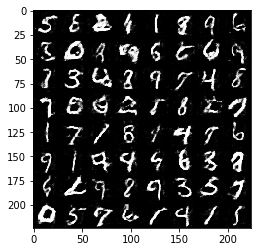

Step 1625, (Epoch 2/2)... Discriminator Loss: 1.4115... Generator Loss: 0.8030
Step 1650, (Epoch 2/2)... Discriminator Loss: 1.4189... Generator Loss: 0.6526
Step 1675, (Epoch 2/2)... Discriminator Loss: 1.4232... Generator Loss: 0.7752
Step 1700, (Epoch 2/2)... Discriminator Loss: 1.3935... Generator Loss: 0.7689
Step 1725, (Epoch 2/2)... Discriminator Loss: 1.4151... Generator Loss: 0.8178
Step 1750, (Epoch 2/2)... Discriminator Loss: 1.3933... Generator Loss: 0.7460
Step 1775, (Epoch 2/2)... Discriminator Loss: 1.3874... Generator Loss: 0.7278
Step 1800, (Epoch 2/2)... Discriminator Loss: 1.4050... Generator Loss: 0.7165


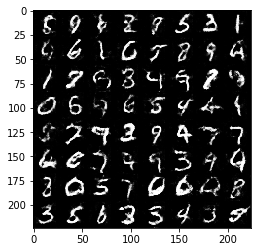

Step 1825, (Epoch 2/2)... Discriminator Loss: 1.4100... Generator Loss: 0.7859
Step 1850, (Epoch 2/2)... Discriminator Loss: 1.4002... Generator Loss: 0.7208


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.3

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Step 25, (Epoch 1/1)... Discriminator Loss: 2.1513... Generator Loss: 0.6187
Step 50, (Epoch 1/1)... Discriminator Loss: 2.0159... Generator Loss: 0.8606
Step 75, (Epoch 1/1)... Discriminator Loss: 1.7198... Generator Loss: 0.6065
Step 100, (Epoch 1/1)... Discriminator Loss: 1.6899... Generator Loss: 0.6064
Step 125, (Epoch 1/1)... Discriminator Loss: 1.5571... Generator Loss: 0.6968
Step 150, (Epoch 1/1)... Discriminator Loss: 1.5096... Generator Loss: 0.5642
Step 175, (Epoch 1/1)... Discriminator Loss: 1.4821... Generator Loss: 0.6530
Step 200, (Epoch 1/1)... Discriminator Loss: 1.5019... Generator Loss: 0.5940


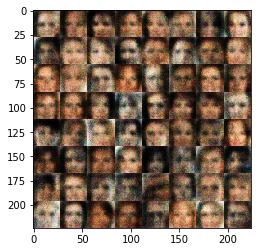

Step 225, (Epoch 1/1)... Discriminator Loss: 1.4648... Generator Loss: 0.5413
Step 250, (Epoch 1/1)... Discriminator Loss: 1.4706... Generator Loss: 0.5954
Step 275, (Epoch 1/1)... Discriminator Loss: 1.4763... Generator Loss: 0.5905
Step 300, (Epoch 1/1)... Discriminator Loss: 1.4626... Generator Loss: 0.6521
Step 325, (Epoch 1/1)... Discriminator Loss: 1.4700... Generator Loss: 0.5824
Step 350, (Epoch 1/1)... Discriminator Loss: 1.4859... Generator Loss: 0.5768
Step 375, (Epoch 1/1)... Discriminator Loss: 1.4330... Generator Loss: 0.5317
Step 400, (Epoch 1/1)... Discriminator Loss: 1.4652... Generator Loss: 0.5547


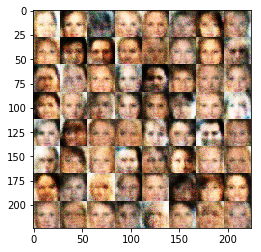

Step 425, (Epoch 1/1)... Discriminator Loss: 1.4376... Generator Loss: 0.5655
Step 450, (Epoch 1/1)... Discriminator Loss: 1.4845... Generator Loss: 0.6629
Step 475, (Epoch 1/1)... Discriminator Loss: 1.4616... Generator Loss: 0.5698
Step 500, (Epoch 1/1)... Discriminator Loss: 1.4537... Generator Loss: 0.5457
Step 525, (Epoch 1/1)... Discriminator Loss: 1.4526... Generator Loss: 0.6863
Step 550, (Epoch 1/1)... Discriminator Loss: 1.4703... Generator Loss: 0.6061
Step 575, (Epoch 1/1)... Discriminator Loss: 1.4481... Generator Loss: 0.6708
Step 600, (Epoch 1/1)... Discriminator Loss: 1.4592... Generator Loss: 0.5914


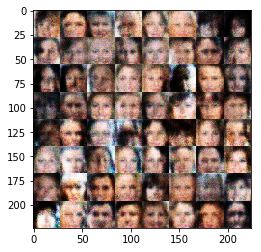

Step 625, (Epoch 1/1)... Discriminator Loss: 1.4438... Generator Loss: 0.6666
Step 650, (Epoch 1/1)... Discriminator Loss: 1.4568... Generator Loss: 0.5850
Step 675, (Epoch 1/1)... Discriminator Loss: 1.3999... Generator Loss: 0.6235
Step 700, (Epoch 1/1)... Discriminator Loss: 1.4021... Generator Loss: 0.6329
Step 725, (Epoch 1/1)... Discriminator Loss: 1.4207... Generator Loss: 0.6072
Step 750, (Epoch 1/1)... Discriminator Loss: 1.4340... Generator Loss: 0.6273
Step 775, (Epoch 1/1)... Discriminator Loss: 1.4281... Generator Loss: 0.6562
Step 800, (Epoch 1/1)... Discriminator Loss: 1.4180... Generator Loss: 0.5986


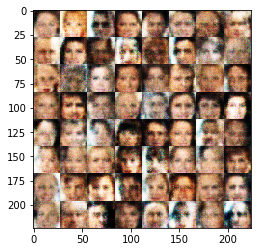

Step 825, (Epoch 1/1)... Discriminator Loss: 1.4208... Generator Loss: 0.6333
Step 850, (Epoch 1/1)... Discriminator Loss: 1.4253... Generator Loss: 0.5955
Step 875, (Epoch 1/1)... Discriminator Loss: 1.4200... Generator Loss: 0.5278
Step 900, (Epoch 1/1)... Discriminator Loss: 1.4256... Generator Loss: 0.6210
Step 925, (Epoch 1/1)... Discriminator Loss: 1.4229... Generator Loss: 0.5573
Step 950, (Epoch 1/1)... Discriminator Loss: 1.4443... Generator Loss: 0.5760
Step 975, (Epoch 1/1)... Discriminator Loss: 1.4252... Generator Loss: 0.6589
Step 1000, (Epoch 1/1)... Discriminator Loss: 1.4520... Generator Loss: 0.5584


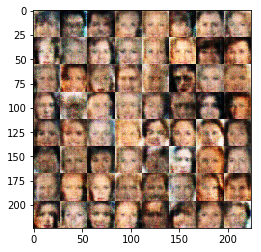

Step 1025, (Epoch 1/1)... Discriminator Loss: 1.4071... Generator Loss: 0.6146
Step 1050, (Epoch 1/1)... Discriminator Loss: 1.4079... Generator Loss: 0.5794
Step 1075, (Epoch 1/1)... Discriminator Loss: 1.4011... Generator Loss: 0.6819
Step 1100, (Epoch 1/1)... Discriminator Loss: 1.4116... Generator Loss: 0.6326
Step 1125, (Epoch 1/1)... Discriminator Loss: 1.4007... Generator Loss: 0.6144
Step 1150, (Epoch 1/1)... Discriminator Loss: 1.4232... Generator Loss: 0.5735
Step 1175, (Epoch 1/1)... Discriminator Loss: 1.4135... Generator Loss: 0.5648
Step 1200, (Epoch 1/1)... Discriminator Loss: 1.4311... Generator Loss: 0.5918


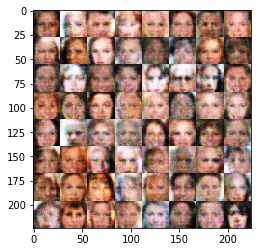

Step 1225, (Epoch 1/1)... Discriminator Loss: 1.4267... Generator Loss: 0.6602
Step 1250, (Epoch 1/1)... Discriminator Loss: 1.3984... Generator Loss: 0.6077
Step 1275, (Epoch 1/1)... Discriminator Loss: 1.4113... Generator Loss: 0.5946


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.